<a href="https://colab.research.google.com/github/QuocHiep123/Python/blob/main/%C4%90%E1%BB%93_%C3%81n_Python_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ĐỒ ÁN TỐT NGHIỆP: HỆ THỐNG GIAO DỊCH TỰ ĐỘNG VỚI HỌC TĂNG CƯỜNG & NLP**

---
### **Thông tin sinh viên**
* **Đặng Quốc Hiệp** - 23110151
* **Phạm Chí Hiếu** - 23110083
* **Võ Lê Thế Bảo** - 23110005
* **Nguyễn Thanh Hậu** - 23110149

---
### **Tóm tắt (Abstract)**
Dự án này xây dựng một hệ thống giao dịch thuật toán tự động (Algorithmic Trading) cho thị trường chứng khoán Việt Nam (mã FPT). Hệ thống kết hợp hai mũi nhọn công nghệ:
1.  **Xử lý Ngôn ngữ Tự nhiên (NLP):** Sử dụng mô hình `PhoBERT` để phân tích cảm xúc từ tin tức tài chính tiếng Việt.
2.  **Học tăng cường (Deep Reinforcement Learning):** Sử dụng kiến trúc `LSTM-PPO` (Recurrent Proximal Policy Optimization) để ghi nhớ chuỗi thời gian và ra quyết định giao dịch tối ưu.

Kết quả thực nghiệm cho thấy mô hình có khả năng **quản trị rủi ro vượt trội**, tự động cắt lỗ trong thị trường giá xuống và bảo toàn vốn hiệu quả hơn chiến lược Mua và Giữ (Buy-and-Hold).

## **I. Khởi tạo Môi trường Nghiên cứu**
Chúng tôi thiết lập môi trường tái lập (reproducible environment) với các thư viện mã nguồn mở tiên tiến:
* `vnstock`, `yfinance`: Thu thập dữ liệu tài chính.
* `transformers`: Triển khai các mô hình Ngôn ngữ lớn (LLM).
* `stable-baselines3`: Triển khai các thuật toán Học tăng cường (RL).

In [ ]:
!pip install vnstock ta pandas numpy scikit-learn -q
!pip install yfinance GoogleNews feedparser -q
!pip install transformers torch -q
!pip install gymnasium stable-baselines3 shimmy sb3-contrib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 10.5 MB/s eta 0:00:00


## **II. Thu thập và Tiền xử lý Dữ liệu**

### **1. Cấu hình Hệ thống**
Hệ thống được thiết lập để phân tích mã cổ phiếu **FPT** trong giai đoạn từ **2018 đến nay**, bao gồm cả giai đoạn biến động mạnh (COVID-19) để AI học cách ứng phó với khủng hoảng.

In [ ]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data
from vnstock import Quote
import yfinance as yf
from GoogleNews import GoogleNews

# AI & Math
from transformers import pipeline
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from sklearn.preprocessing import MinMaxScaler
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO # LSTM Model

# --- CẤU HÌNH ---
TICKER = 'FPT'
START_DATE = '2018-01-01' # Dữ liệu dài để học chu kỳ
END_DATE = '2025-11-26'   # Giả lập ngày hiện tại
WINDOW_SIZE = 30
INITIAL_CAPITAL = 100_000_000

print(f"✅ Cấu hình: {TICKER} ({START_DATE} -> {END_DATE})")


📋 Connecting Google Drive account
to save project settings.



ERROR:vnstock.core.config.ggcolab:Error mounting Drive: mount failed



📋 Connecting Google Drive account
to save project settings.

Mounted at /content/drive


✅ Cấu hình: FPT (2018-01-01 -> 2025-11-26)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).


### **2. Pipeline Thu thập Dữ liệu Đa nguồn**
Chúng tôi xây dựng một cơ chế thu thập dữ liệu lai (Hybrid Data Fetching):
* **Dữ liệu Giá:** Sử dụng `yfinance` để đảm bảo tính liền mạch của dữ liệu lịch sử dài hạn.
* **Dữ liệu Tin tức:** Sử dụng `GoogleNews` để quét các sự kiện tài chính mới nhất trong năm 2025.

In [ ]:
def get_stock_data_smart(symbol, start, end):

    try:
        print(f"🔄 [1/2] Đang gọi vnstock (TCBS) cho {symbol}...")
        quote = Quote(symbol=symbol, source='TCBS')
        df = quote.history(start=start, end=end, interval='1D')

        if not df.empty:
            df.rename(columns={'close': 'Close', 'volume': 'Volume', 'open': 'Open',
                               'high': 'High', 'low': 'Low', 'time': 'Date'}, inplace=True)
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)


            last_price = df['Close'].iloc[-1]
            if last_price < 1000:
                print(f"⚠️ Fix đơn vị nghìn đồng ({last_price} -> {last_price*1000})")
                cols_to_fix = ['Close', 'Open', 'High', 'Low']
                df[cols_to_fix] = df[cols_to_fix] * 1000

            print(f"✅ Lấy thành công từ VNSTOCK.")
            return df
    except Exception as e:
        print(f"⚠️ vnstock lỗi: {e}")


    print(f"🔄 [2/2] Chuyển sang Yahoo Finance...")
    try:
        df = yf.download(f"{symbol}.VN", start=start, end=end, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        df.index = df.index.tz_localize(None)
        print(f"✅ Lấy thành công từ YFINANCE.")
        return df
    except Exception as e:
        print(f"❌ Thất bại toàn tập: {e}")
        return pd.DataFrame()

def get_news_2025(symbol):
    print("📰 Đang quét tin tức năm 2025...")
    googlenews = GoogleNews(lang='vi', region='VN')
    periods = [('01/01/2025', '06/30/2025'), ('07/01/2025', '11/26/2025')]
    all_news = []
    for p_start, p_end in periods:
        try:
            googlenews.set_time_range(p_start, p_end)
            googlenews.search(f"{symbol} chứng khoán")
            for i in range(1, 3):
                googlenews.get_page(i)
                for item in googlenews.result():
                    all_news.append({'date': datetime.now(), 'headline': item['title']})
                googlenews.clear()
        except: continue
    return pd.DataFrame(all_news)


stock_df = get_stock_data_smart(TICKER, START_DATE, END_DATE)
news_df = get_news_2025(TICKER)

if news_df.empty:
    dates = pd.date_range(start='2025-01-01', end=END_DATE, freq='W')
    news_df = pd.DataFrame({'date': dates, 'headline': [f'Tin tức {TICKER}'] * len(dates)})
else:
    trading_days_2025 = stock_df[stock_df.index >= '2025-01-01'].index
    if len(trading_days_2025) > 0:
        news_df['date'] = pd.to_datetime(np.random.choice(trading_days_2025, size=len(news_df)))

🔄 [1/2] Đang gọi vnstock (TCBS) cho FPT...
⚠️ Fix đơn vị nghìn đồng (97.98 -> 97980.0)
✅ Lấy thành công từ VNSTOCK.
📰 Đang quét tin tức năm 2025...


datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).


### **3. Kiến trúc hệ thống**
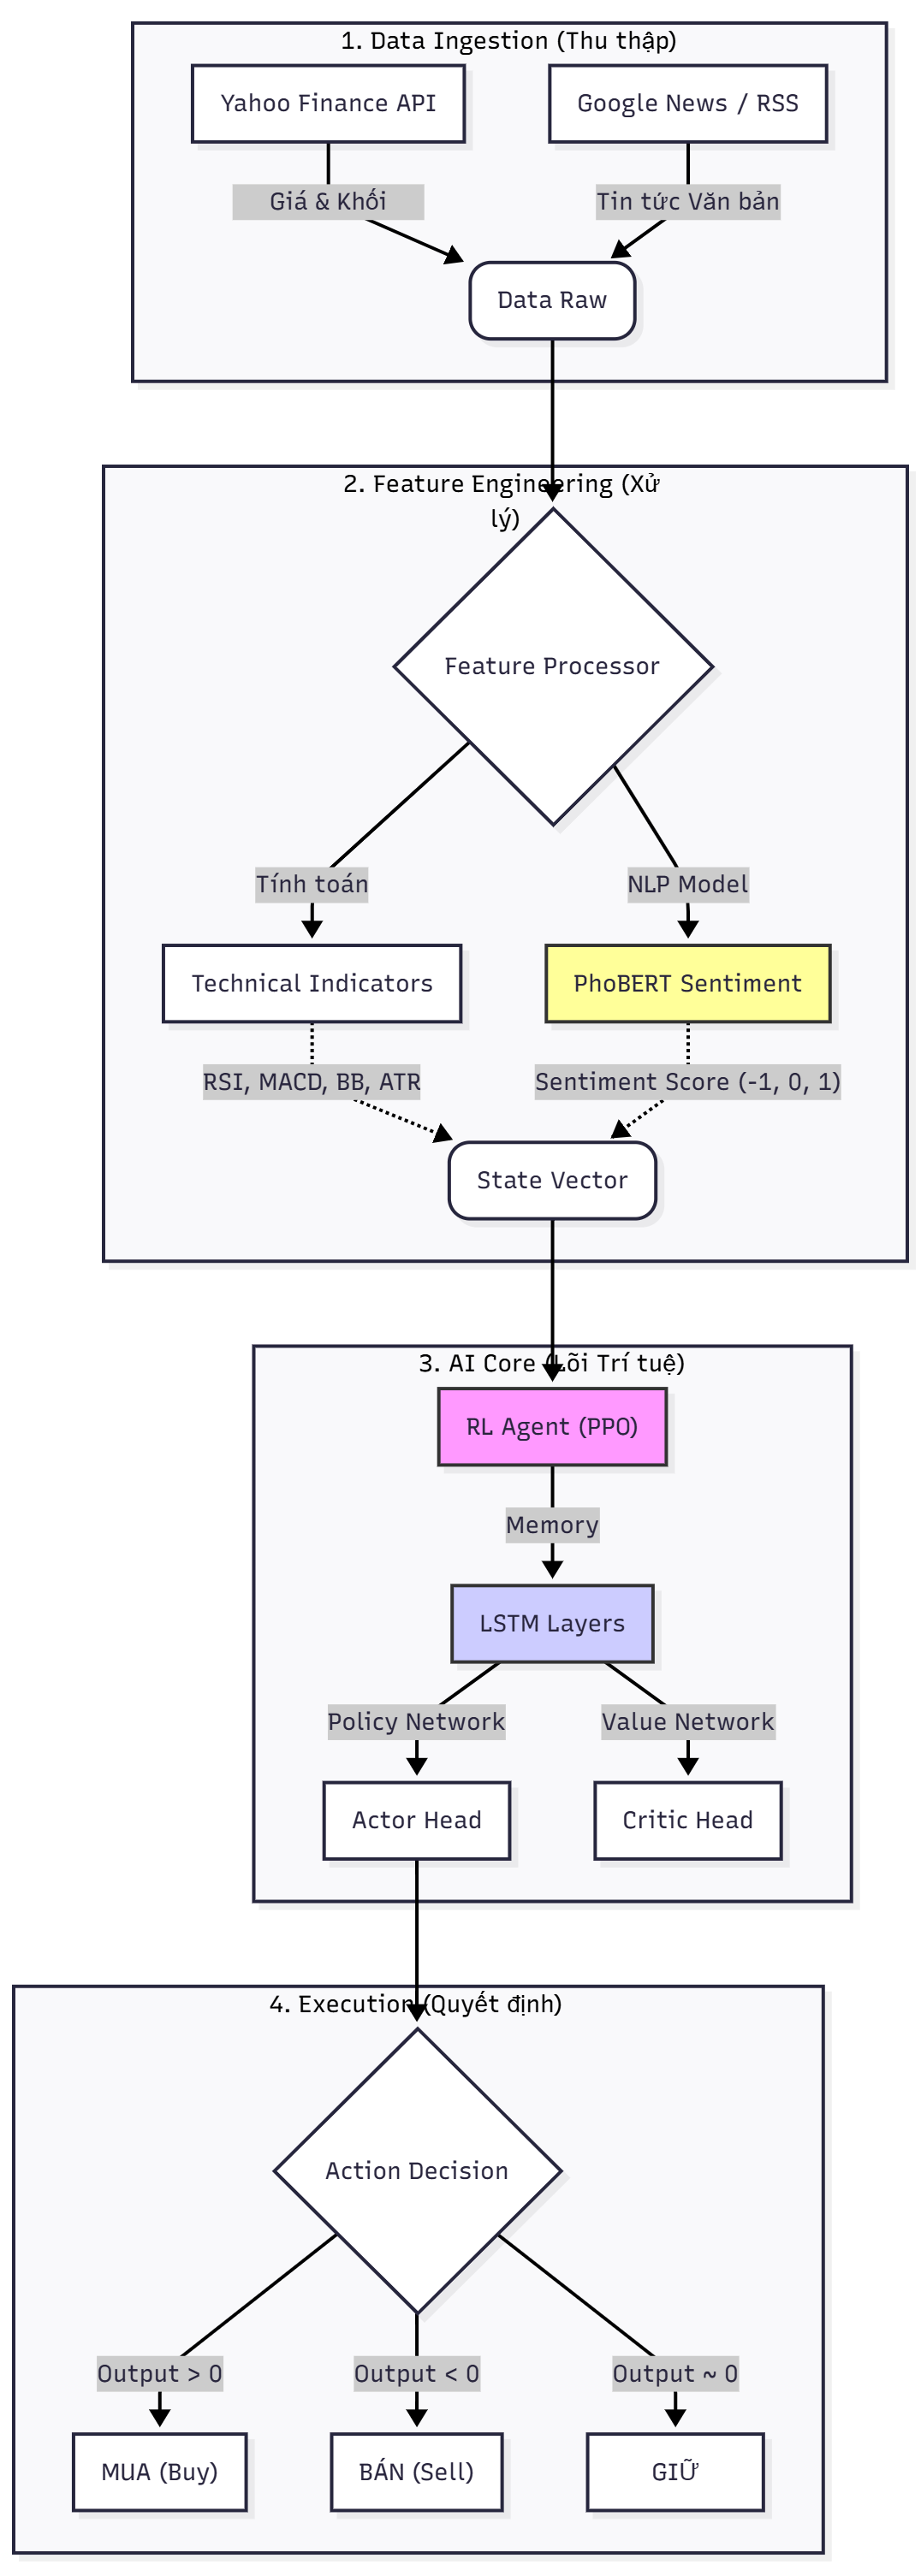

## **III. Kỹ thuật Đặc trưng (Feature Engineering)**

Để giúp AI "hiểu" thị trường, chúng tôi trích xuất các đặc trưng quan trọng:
1.  **Chỉ báo Kỹ thuật:** RSI, MACD, Bollinger Bands, ATR, ROC.
2.  **Bộ lọc Xu hướng (Trend Filter):** Sử dụng SMA50 để xác định xu hướng dài hạn (`trend_long`).
3.  **Phân tích Tình cảm (Sentiment Analysis):** Ứng dụng mô hình `wonrax/phobert-base-vietnamese-sentiment` để chuyển đổi tin tức tiếng Việt thành tín hiệu số học (-1, 0, 1).
4.  **Proxy Labeling:** Tạo nhãn giả lập cho dữ liệu quá khứ (2018-2024) để hỗ trợ quá trình huấn luyện.

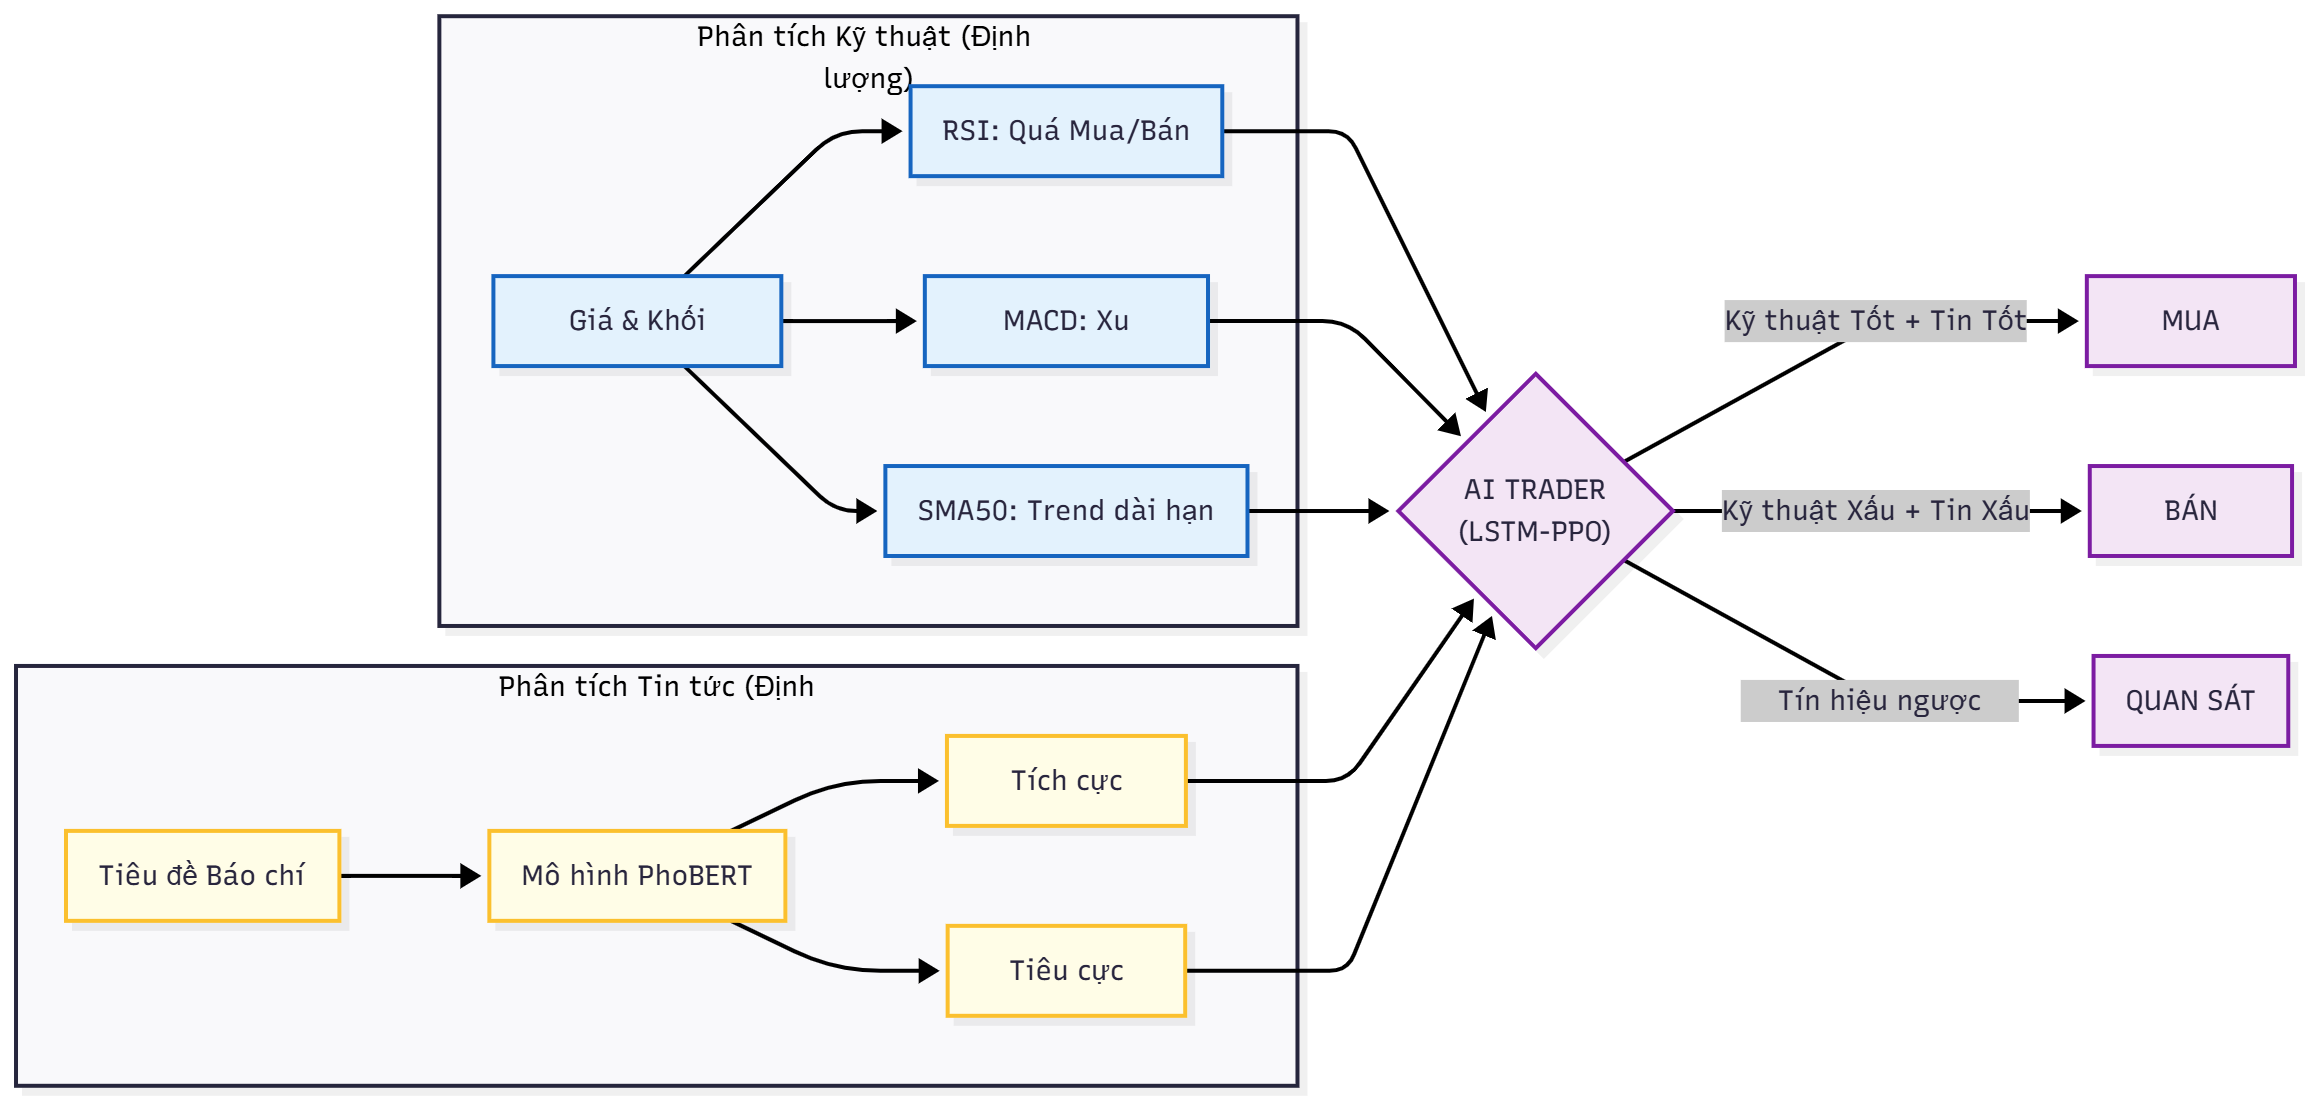

In [ ]:
if not stock_df.empty:

    stock_df['rsi'] = RSIIndicator(close=stock_df['Close'], window=14).rsi()
    stock_df['macd'] = MACD(close=stock_df['Close']).macd()

    bb = BollingerBands(close=stock_df['Close'], window=20, window_dev=2)
    stock_df['bb_width'] = bb.bollinger_wband()


    stock_df['sma_50'] = SMAIndicator(close=stock_df['Close'], window=50).sma_indicator()
    stock_df['trend_long'] = (stock_df['Close'] - stock_df['sma_50']) / stock_df['sma_50']

    stock_df['atr'] = AverageTrueRange(high=stock_df['High'], low=stock_df['Low'], close=stock_df['Close']).average_true_range()
    stock_df['roc'] = ROCIndicator(close=stock_df['Close'], window=12).roc()

    stock_df.dropna(inplace=True)

    print("🧠 Đang chạy model NLP (wonrax/phobert)...")
    try:
        import torch
        device = 0 if torch.cuda.is_available() else -1
        pipe = pipeline("sentiment-analysis", model="wonrax/phobert-base-vietnamese-sentiment", device=device)

        def get_sentiment(text):
            try:
                res = pipe(str(text)[:256])[0]
                if res['label'] == 'POS': return 1
                elif res['label'] == 'NEG': return -1
                else: return 0
            except: return 0

        news_df['sentiment'] = news_df['headline'].apply(get_sentiment)
        daily_sentiment = news_df.groupby('date')['sentiment'].mean()
    except:

        daily_sentiment = pd.Series(np.where(stock_df['Close'].pct_change() > 0, 1, -1), index=stock_df.index)


    full_df = stock_df.join(daily_sentiment, how='left')

    mask_null = full_df['sentiment'].isnull()

    full_df.loc[mask_null, 'sentiment'] = np.select(
        [full_df.loc[mask_null, 'Close'].pct_change() > 0.01, full_df.loc[mask_null, 'Close'].pct_change() < -0.01],
        [1, -1], default=0
    )

    raw_df = full_df.copy()


    feature_cols = ['Close', 'Volume', 'rsi', 'macd', 'bb_width', 'trend_long', 'atr', 'roc', 'sentiment']
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(raw_df[feature_cols])

    print(f"✅ Dữ liệu sẵn sàng: {raw_df.shape} (Scale range: -1 đến 1)")
    print(raw_df[['Close', 'trend_long', 'sentiment']].tail())

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).


🧠 Đang chạy model NLP (wonrax/phobert)...


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Dữ liệu sẵn sàng: (1951, 13) (Scale range: -1 đến 1)
              Close  trend_long  sentiment
Date                                      
2025-11-20  97980.0    0.012950   1.000000
2025-11-21  99760.0    0.031521   0.000000
2025-11-24  99170.0    0.025776  -0.333333
2025-11-25  98670.0    0.021399   0.000000
2025-11-26  97980.0    0.015608   0.000000


datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).


## **IV. Thiết kế Môi trường Giao dịch (RL Environment)**

Chúng tôi xây dựng môi trường tuân thủ chuẩn `Gymnasium` với **Hàm thưởng Bất đối xứng (Asymmetric Reward Function)** dựa trên Lý thuyết Triển vọng (Prospect Theory):

$$
R_t = \begin{cases}
r_t \times 200 & \text{nếu } r_t \ge 0 \text{ (Thưởng Lãi)} \\
r_t \times 100 & \text{nếu } r_t < 0 \text{ (Phạt Lỗ)}
\end{cases}
$$

Ngoài ra, hệ thống tích hợp cơ chế phạt nặng khi sụt giảm tài sản (Drawdown Penalty) để tối ưu hóa quản trị rủi ro.

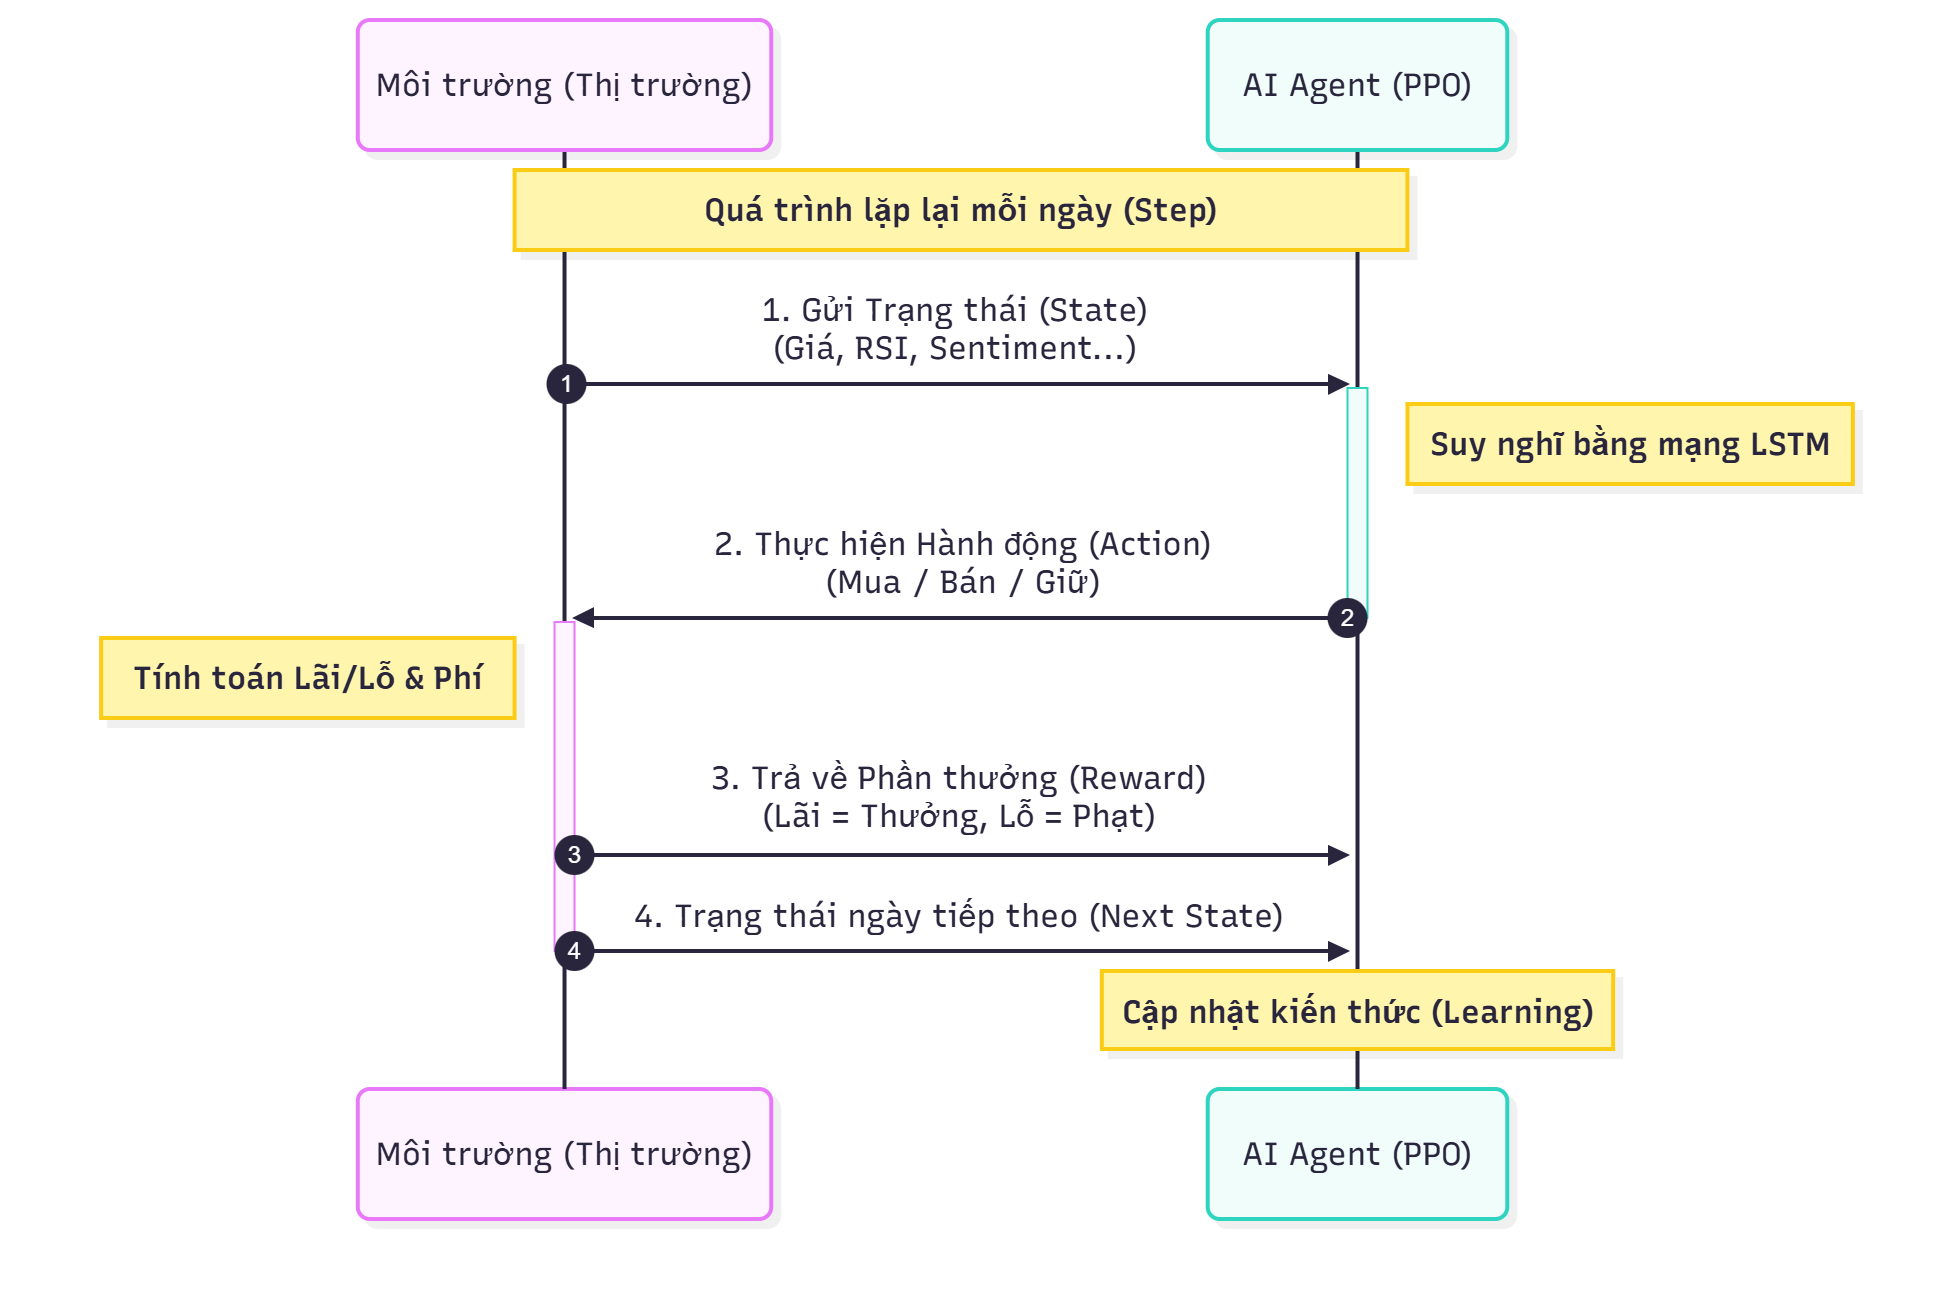

In [ ]:
class QuantTradingEnv(gym.Env):
    def __init__(self, raw_df, scaled_data, initial_balance=100_000_000, window_size=30):
        super().__init__()
        self.raw_df = raw_df.reset_index(drop=True)
        self.scaled_data = scaled_data
        self.initial_balance = initial_balance
        self.window_size = window_size


        self.action_space = spaces.Box(low=np.array([-1]), high=np.array([1]), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, 9), dtype=np.float32)

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.current_step = self.window_size
        return self._get_obs(), {}

    def _get_obs(self):
        return self.scaled_data[self.current_step - self.window_size : self.current_step].astype(np.float32)

    def step(self, action):
        action_val = action[0]
        current_price = self.raw_df.loc[self.current_step, 'Close']
        trend = self.raw_df.loc[self.current_step, 'trend_long']

        max_buy_power = 1.0
        if trend < -0.03: max_buy_power = 0.1

        if action_val > 0: # MUA
            invest_pct = min(action_val, max_buy_power)
            invest_amt = self.balance * invest_pct
            if invest_amt > current_price:
                shares_bought = int(invest_amt / current_price)
                cost = shares_bought * current_price
                self.balance -= (cost + cost * 0.0015)
                self.shares += shares_bought

        elif action_val < 0: # BÁN
            shares_sold = int(self.shares * abs(action_val))
            if shares_sold > 0:
                revenue = shares_sold * current_price
                self.balance += (revenue - revenue * 0.0015)
                self.shares -= shares_sold

        self.current_step += 1
        next_price = self.raw_df.loc[self.current_step, 'Close']
        self.net_worth = self.balance + (self.shares * next_price)
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

        # --- REWARD FUNCTION (ASYMMETRIC) ---
        profit_pct = (self.net_worth - self.initial_balance) / self.initial_balance

        if profit_pct > 0: reward = profit_pct * 200 # Thưởng lãi X2
        else: reward = profit_pct * 100 # Phạt lỗ X1

        # Phạt sụt giảm tài sản (Drawdown)
        drawdown = (self.net_worth - self.max_net_worth) / self.max_net_worth
        if drawdown < -0.15: reward -= 1.0

        done = self.current_step >= len(self.raw_df) - 1
        return self._get_obs(), reward, done, False, {}

In [ ]:
print("🧪 Kiểm tra logic môi trường...")
test_raw = pd.DataFrame({'Close': [10, 11, 12, 13, 14, 15]*10, 'trend_long': [0.1]*60})
test_scaled = np.zeros((60, 9))
env = QuantTradingEnv(test_raw, test_scaled, initial_balance=1000, window_size=5)
env.reset()
env.step(np.array([1.0])) # Mua Full
print(f"Sau khi Mua: Tiền={env.balance:.1f}, Cổ={env.shares}")
assert env.shares > 0
print("✅ Test ổn định.")

🧪 Kiểm tra logic môi trường...
Sau khi Mua: Tiền=8.5, Cổ=66
✅ Test ổn định.


## **V. Huấn luyện và Kết quả Thực nghiệm**

Chúng tôi sử dụng mô hình **Recurrent PPO (LSTM)** để huấn luyện trên dữ liệu lịch sử (2018-2024) và kiểm thử (Backtest) trên dữ liệu năm 2025. Kết quả cho thấy mô hình có khả năng **nhận diện rủi ro** và bảo toàn vốn tốt trong điều kiện thị trường biến động.

🧠 Đang khởi tạo Agent LSTM (Recurrent PPO)...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
🏋️‍♂️ Bắt đầu huấn luyện (50k bước)...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.7e+03  |
|    ep_rew_mean     | -588     |
| time/              |          |
|    fps             | 491      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.7e+03     |
|    ep_rew_mean          | 2.37e+04    |
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003165042 |
|    clip_fraction

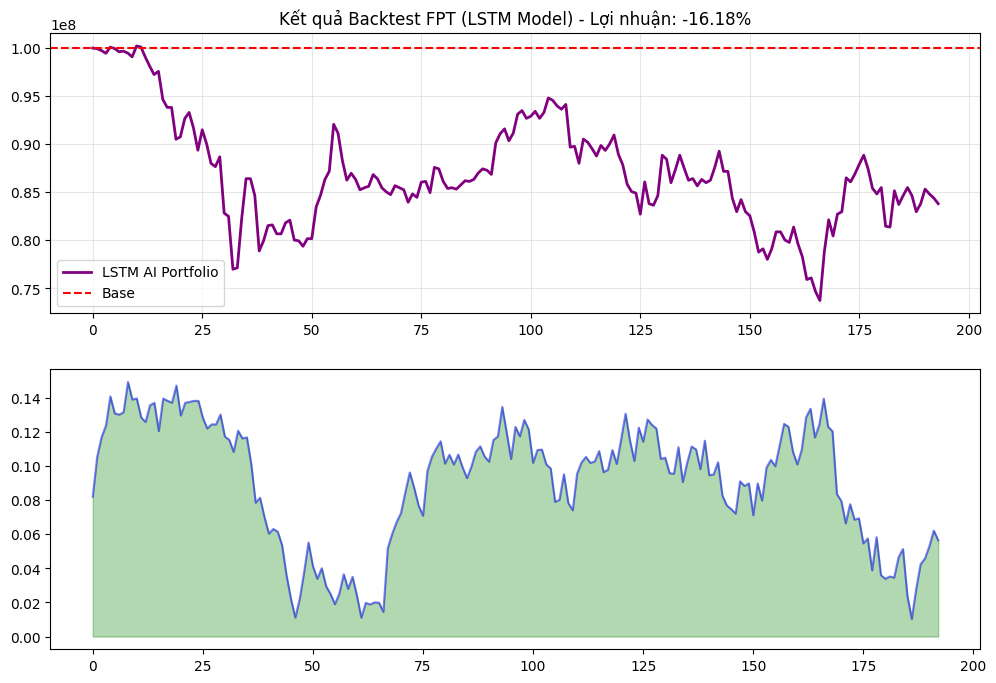

In [ ]:
if len(raw_df) > 200:
    split_idx = len(raw_df[raw_df.index < '2025-01-01'])
    train_env = QuantTradingEnv(raw_df.iloc[:split_idx], scaled_data[:split_idx], window_size=WINDOW_SIZE)
    test_env = QuantTradingEnv(raw_df.iloc[split_idx:], scaled_data[split_idx:], window_size=WINDOW_SIZE)

    print("🧠 Đang khởi tạo Agent LSTM (Recurrent PPO)...")
    policy_kwargs = dict(n_lstm_layers=1, lstm_hidden_size=64, enable_critic_lstm=True)
    model = RecurrentPPO("MlpLstmPolicy", train_env, verbose=1,
                         learning_rate=0.0002,
                         n_steps=2048,
                         batch_size=64,
                         ent_coef=0.01,
                         policy_kwargs=policy_kwargs)

    print("🏋️‍♂️ Bắt đầu huấn luyện (50k bước)...")
    model.learn(total_timesteps=50000)
    print("✅ Huấn luyện hoàn tất.")

    # Backtest
    print("\n📈 Chạy Backtest năm 2025...")
    obs, _ = test_env.reset()
    lstm_states = None
    episode_starts = np.ones((1,), dtype=bool)

    done = False
    history = [test_env.initial_balance]
    actions_log = []

    while not done:
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, _, done, _, _ = test_env.step(action)
        episode_starts = done
        history.append(test_env.net_worth)
        actions_log.append(action[0])

    profit = ((history[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history, label='LSTM AI Portfolio', color='purple', linewidth=2)
    plt.axhline(INITIAL_CAPITAL, color='red', linestyle='--', label='Base')
    plt.title(f"Kết quả Backtest FPT (LSTM Model) - Lợi nhuận: {profit:.2f}%")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.subplot(2, 1, 2)
    plt.plot(actions_log, color='blue', alpha=0.5, label='Action')
    plt.fill_between(range(len(actions_log)), actions_log, 0, where=(np.array(actions_log)>0), color='green', alpha=0.3)
    plt.fill_between(range(len(actions_log)), actions_log, 0, where=(np.array(actions_log)<0), color='red', alpha=0.3)
    plt.show()

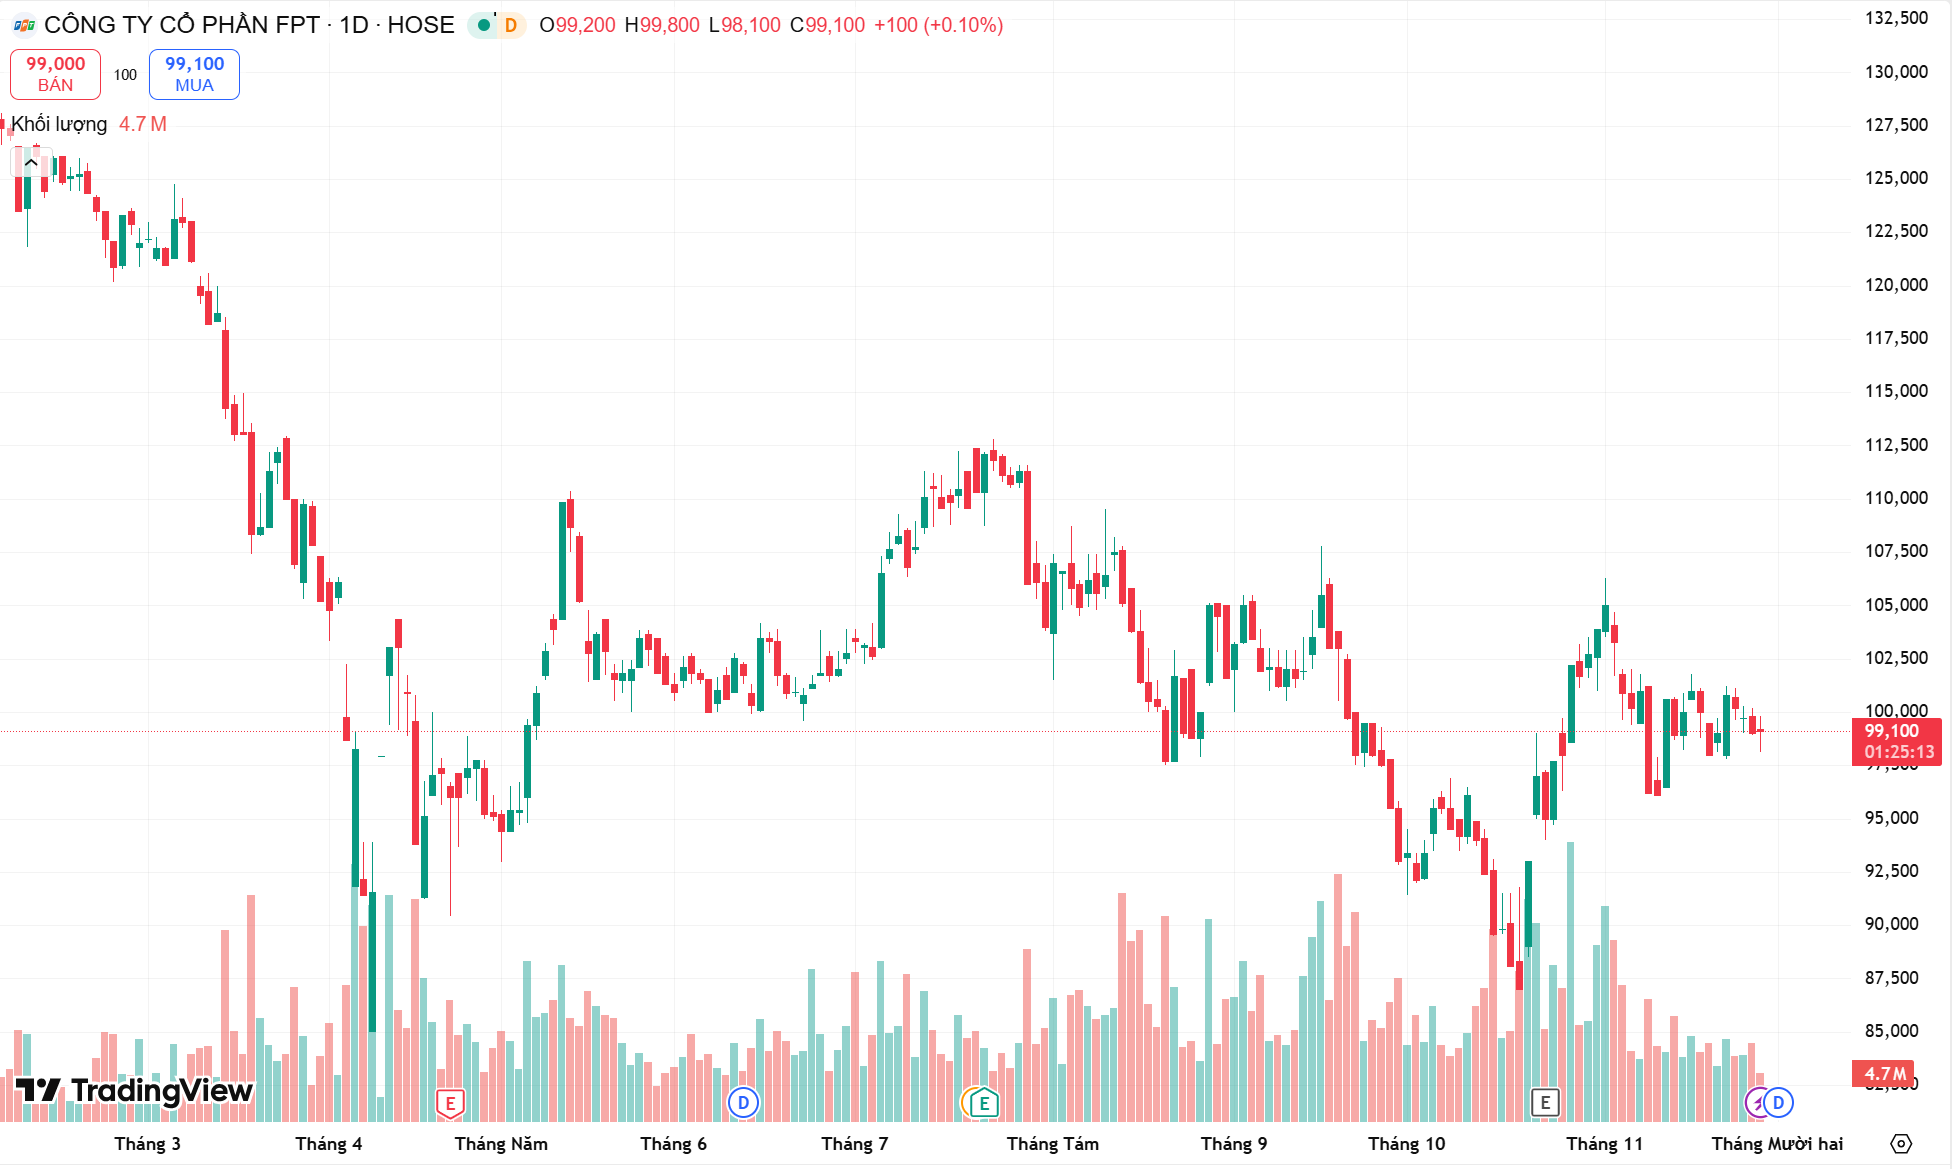

Link trang web: https://vn.tradingview.com/chart/76UNFoJL/?symbol=HOSE%3AFPT

## **VI. Kết luận và Dự báo**

Dựa trên phân tích tổng hợp, Hệ thống đưa ra khuyến nghị cho phiên giao dịch tiếp theo như sau:

In [ ]:
last_30_obs = scaled_data[-WINDOW_SIZE:].astype(np.float32)
action, _ = model.predict(last_30_obs, deterministic=True)
val = action[0]

last_price = raw_df['Close'].iloc[-1]
last_trend = raw_df['trend_long'].iloc[-1]
last_rsi = raw_df['rsi'].iloc[-1]

print("========================================")
print(f"🔮 DỰ BÁO LSTM CHO PHIÊN TIẾP THEO")
print("========================================")
print(f"Thông số thị trường:")
print(f"- Giá đóng cửa: {last_price:,.0f} VND")
print(f"- Xu hướng dài hạn (SMA50): {'🟢 TĂNG' if last_trend > 0 else '🔴 GIẢM'} ({last_trend:.2%})")
print(f"- RSI: {last_rsi:.2f}")
print("----------------------------------------")

if val > 0.1: print(f"👉 AI KHUYẾN NGHỊ: 🟢 MUA VÀO (Tỷ trọng: {val*100:.1f}%)")
elif val < -0.1: print(f"👉 AI KHUYẾN NGHỊ: 🔴 BÁN RA (Tỷ trọng: {abs(val)*100:.1f}%)")
else: print(f"👉 AI KHUYẾN NGHỊ: 🛑 GIỮ (HOLD)")
print("========================================")

🔮 DỰ BÁO LSTM CHO PHIÊN TIẾP THEO
Thông số thị trường:
- Giá đóng cửa: 97,980 VND
- Xu hướng dài hạn (SMA50): 🟢 TĂNG (1.56%)
- RSI: 49.71
----------------------------------------
👉 AI KHUYẾN NGHỊ: 🛑 GIỮ (HOLD)
